In [21]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 2000) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [22]:
internet = pd.read_csv('new_file.csv')

In [3]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 56 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   population        1318 non-null   int64  
 1   unemp             1318 non-null   float64
 2   health_ins        1318 non-null   float64
 3   poverty           1318 non-null   float64
 4   SNAP              1318 non-null   float64
 5   no_comp           1318 non-null   float64
 6   no_internet       1318 non-null   float64
 7   home_broad        1318 non-null   float64
 8   broad_num         1318 non-null   float64
 9   broad_avail       1318 non-null   float64
 10  broad_cost        1318 non-null   float64
 11  population_bbn    1318 non-null   float64
 12  price_bbn         1318 non-null   float64
 13  wired_bbn         1318 non-null   float64
 14  provide_bbn       1318 non-null   float64
 15  all25_bbn         1318 non-null   float64
 16  downave_bbn       1318 non-null   float64


In [30]:
internet.head()

,CountyId,population,unemp,health_ins,poverty,SNAP,no_comp,no_internet,home_broad,broad_num,...,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Diversity.Index,Mean
0,1005,24686,3.8000,11.2000,28.9000,27.4000,23.9000,38.9000,60.4000,4,...,1.3000,23.4000,8878,74.1000,19.1000,6.5000,0.3000,12.4000,0.5566,411
1,1015,113605,3.5000,9.4000,18.6000,17.9000,15.3000,26.6000,73.0000,2,...,3.2000,24.8000,47392,74.9000,19.9000,5.1000,0.1000,10.1000,0.4204,600
2,1017,33254,2.9000,10.8000,16.6000,14.7000,24.2000,33.0000,66.5000,1,...,2.0000,23.6000,14527,84.5000,11.8000,3.7000,0.0000,6.4000,0.5171,854
3,1019,26196,2.9000,8.3000,15.0000,15.9000,19.9000,31.0000,68.6000,2,...,2.0000,26.5000,9879,74.8000,17.1000,8.1000,0.0000,5.3000,0.1548,864
4,1021,44428,2.7000,14.2000,18.6000,18.2000,22.0000,37.7000,61.8000,2,...,1.7000,32.5000,17675,81.1000,14.0000,4.5000,0.4000,6.7000,0.3320,0


Text(0.5, 1.0, 'Correlation Matrix')

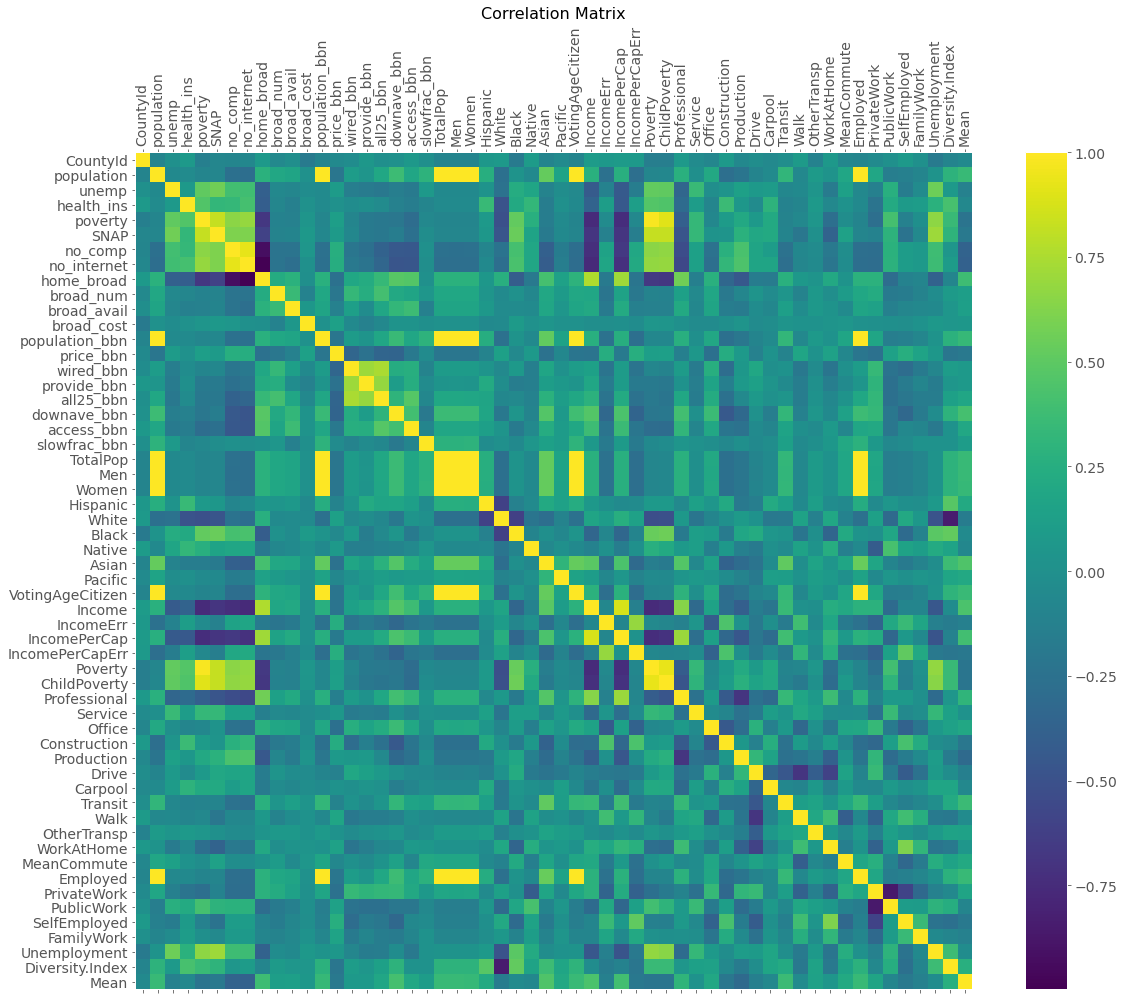

In [33]:
df = internet
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [34]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [25]:
#internet_new = drop_column_using_vif_(internet.drop('price_bbn', axis=1))

In [35]:
internet.head()
df = pd.DataFrame(internet)

# name of the new file
filename = "vif_new_try.csv"

# writing to the new file
df.to_csv(filename, index=False)

In [36]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
df = pd.read_csv('vif_new_try.csv', index_col=13)
data_standardised = df.copy()
for c in df.columns.values:
    data_standardised[c] = mms.fit_transform(df[c].values.reshape(-1,1))
data_standardised.head()

,CountyId,population,unemp,health_ins,poverty,SNAP,no_comp,no_internet,home_broad,broad_num,...,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Diversity.Index,Mean
price_bbn,,,,,,,,,,,,,,,,,,,,,
35.0000,0.0000,0.0024,0.1600,0.2513,0.5670,0.6555,0.3731,0.4964,0.4971,0.2143,...,0.0428,0.4625,0.0018,0.7434,0.3126,0.1949,0.0492,0.4321,0.7392,0.1238
35.0000,0.0002,0.0113,0.1400,0.2032,0.3371,0.4282,0.2305,0.3205,0.6777,0.0714,...,0.1167,0.5045,0.0098,0.7575,0.3310,0.1444,0.0164,0.3519,0.5460,0.1807
35.0000,0.0002,0.0033,0.1000,0.2406,0.2924,0.3517,0.3781,0.4120,0.5845,0.0000,...,0.0700,0.4685,0.0030,0.9274,0.1448,0.0939,0.0000,0.2230,0.6831,0.2572
65.0000,0.0003,0.0026,0.1000,0.1738,0.2567,0.3804,0.3068,0.3834,0.6146,0.0714,...,0.0700,0.5556,0.0020,0.7558,0.2667,0.2527,0.0000,0.1847,0.1691,0.2602
35.0000,0.0003,0.0044,0.0867,0.3316,0.3371,0.4354,0.3416,0.4793,0.5172,0.0714,...,0.0584,0.7357,0.0036,0.8673,0.1954,0.1227,0.0656,0.2334,0.4206,0.0000


In [37]:
data_standardised.columns

Index(['CountyId', 'population', 'unemp', 'health_ins', 'poverty', 'SNAP',
       'no_comp', 'no_internet', 'home_broad', 'broad_num', 'broad_avail',
       'broad_cost', 'population_bbn', 'wired_bbn', 'provide_bbn', 'all25_bbn',
       'downave_bbn', 'access_bbn', 'slowfrac_bbn', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment', 'Diversity.Index', 'Mean'],
      dtype='object')

In [38]:
# using VIF on the bike_rental dataset
df_predictors_selected_VIF = drop_column_using_vif_(data_standardised.drop('all25_bbn', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: TotalPop
Dropping: PrivateWork
Dropping: Professional
Dropping: Drive
Dropping: Women
Dropping: Men
Dropping: population
Dropping: population_bbn
Dropping: no_internet
Dropping: White
Dropping: VotingAgeCitizen
Dropping: Poverty
Dropping: Income
Dropping: poverty
Dropping: home_broad
Dropping: IncomePerCap
The columns remaining after VIF selection are:
Index(['CountyId', 'unemp', 'health_ins', 'SNAP', 'no_comp', 'broad_num',
       'broad_avail', 'broad_cost', 'wired_bbn', 'provide_bbn', 'downave_bbn',
       'access_bbn', 'slowfrac_bbn', 'Hispanic', 'Black', 'Native', 'Asian',
       'Pacific', 'IncomeErr', 'IncomePerCapErr', 'ChildPoverty', 'Service',
       'Office', 'Construction', 'Production', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'Diversity.Index',
       'Mean'],
      dtype='object')


In [39]:
data_standardised_OLS = sm.OLS(endog=data_standardised[['all25_bbn']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
data_standardised_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              all25_bbn   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     88.92
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        22:08:39   Log-Likelihood:                 1439.0
No. Observations:                1318   AIC:                            -2800.
Df Residuals:                    1279   BIC:                            -2598.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1323      0.047     -2.823      0.005      -0.224      -0.040
CountyId           -0.0083      0.009     -0.914      0.361      -0.026       0.009
unemp              -0.0085      0.036     -0.239      0.811      -0.078       0.061
health_ins          0.0121      0.026      0.473      0.637      -0.038       0.063
SNAP                0.0061      0.033      0.188      0.851      -0.058       0.070
no_comp            -0.0802      0.036     -2.248      0.025      -0.150      -0.010
broad_num           0.1112      0.017      6.651      0.000       0.078       0.144
broad_avail        -0.0140      0.012     -1.144      0.253      -0.038       0.010
broad_cost         -0.0391      0.036     -1.083      0.279      -0.110       0.032
wired_bbn           0.5341      0.028     18.848      0.000       0.479       0.590
provide_bbn         0.2455      0.025     10.016      0.000       0.197       0.294
downave_bbn        -0.0011      0.023     -0.048      0.962      -0.045       0.043
access_bbn          0.2209      0.016     13.700      0.000       0.189       0.252
slowfrac_bbn       -0.0090      0.010     -0.904      0.366      -0.029       0.011
Hispanic            0.0468      0.027      1.707      0.088      -0.007       0.101
Black               0.0363      0.027      1.356      0.175      -0.016       0.089
Native              0.0690      0.042      1.656      0.098      -0.013       0.151
Asian               0.1218      0.049      2.471      0.014       0.025       0.219
Pacific             0.0481      0.026      1.828      0.068      -0.004       0.100
IncomeErr           0.0567      0.068      0.830      0.407      -0.077       0.191
IncomePerCapErr     0.0019      0.034      0.058      0.954      -0.064       0.068
ChildPoverty       -0.0078      0.033     -0.239      0.811      -0.072       0.056
Service            -0.0161      0.035     -0.459      0.646      -0.085       0.053
Office             -0.0203      0.032     -0.642      0.521      -0.082       0.042
Construction       -0.0137      0.031     -0.444      0.657      -0.074       0.047
Production          0.0249      0.028      0.875      0.382      -0.031       0.081
Carpool             0.0332      0.025      1.341      0.180      -0.015       0.082
Transit            -0.2137      0.055     -3.875      0.000      -0.322      -0.106
Walk               -0.0056      0.048     -0.115      0.908      -0.101       0.089
OtherTransp         0.0464      0.032      1.470      0.142      -0.016       0.108
WorkAtHome          0.0808      0.034      2.356      0.019       0.014       0.148
MeanCommute         0.0505      0.019      2.663      0.008       0.013       0.088
Employed            0.0694      0.075      0.928      0.354      -0.077       0.216
PublicWork         -0.0195      0.026     -0.746      0.456

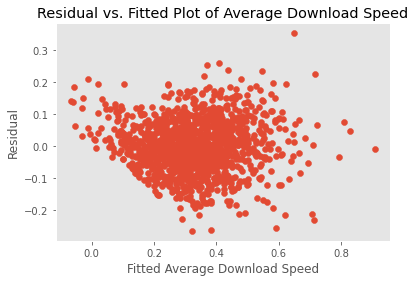

In [40]:
# plot 
plt.scatter(data_standardised_OLS.fittedvalues, data_standardised_OLS.resid)
# adding title and labels
plt.xlabel('Fitted Average Download Speed')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of Average Download Speed')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


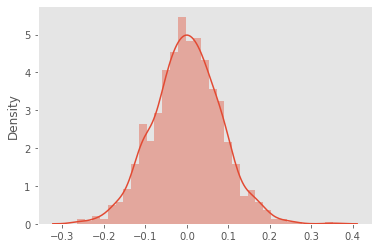

In [41]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


#残差图
residuals = data_standardised_OLS.resid
sns.distplot(residuals, hist=True)
plt.show()


In [56]:
#import numpy as np
#X = np.array([[1, 3, 4, 5],[1, 3, 8, 5],[1, 7, 4, 5],[1, 7, 4, 5]])  #新的输入变量
#y = np.array([1, 2, 3, 5])  #因变量
#X = sm.add_constant(X)
#model = sm.OLS(y, X)
#results = model.fit()
#predictions = results.predict(exog = X)
#print(predictions)
# generate predictions 
#predictions = data_standardised_OLS.predict(exog = sm.add_constant(df_predictors_selected_VIF))
predictions = data_standardised_OLS.predict(exog = sm.add_constant(df_predictors_selected_VIF))
print(predictions)


price_bbn
 35.0000                                     0.3712
 35.0000                                     0.3044
 35.0000                                     0.2490
 65.0000                                     0.2445
 35.0000                                     0.2816
 66.9500                                    -0.0135
 55.0000                                     0.2457
 69.9900                                     0.0209
 35.0000                                     0.3103
 69.9500                                     0.2924
 44.9900                                     0.2365
 69.9900                                     0.1881
 55.0000                                     0.3043
 35.0000                                     0.3938
 69.9900                                     0.1215
 39.9900                                     0.2889
 69.9900                                     0.1397
 55.0000                                     0.0587
 55.0000                                     0.2959
 4

In [63]:
# fit multiple regression model
multiple_regression_model = sm.OLS(endog = data_standardised['all25_bbn'], exog = sm.add_constant(data_standardised.drop(['all25_bbn'], axis = 1))).fit()

# generate predictions
predictions = multiple_regression_model.predict(exog = sm.add_constant(data_standardised.drop(['all25_bbn'], axis = 1)))
#print(predictions)
predictions.head()



price_bbn
35.0000                                     0.3621
35.0000                                     0.3000
35.0000                                     0.2524
65.0000                                     0.2631
35.0000                                     0.2893
dtype: float64

In [62]:
#data_standardised.head()
# name of the new file
filenameya = "data_standardised.csv"

# writing to the new file
data_standardised.to_csv(filenameya, index=False)

In [31]:

import statsmodels.api as sm 
# Fit a linear regression model
 OLS model = sm.OLS(y, X)
results = model.fit() 
# Perform the White test 
white_test = sm.stats.diagnostic.het_white(results.resid, results.model.exog) 
# Print the test statistic and p-value 
print(white_test)


IndentationError: unexpected indent (3986742380.py, line 3)

In [10]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

#读取csv文件
#df = pd.read_csv('vif_new_try.csv')

#建立WLS模型
x = data_standardised[["health_ins","Unemployment"]]
y = data_standardised["all25_bbn"]
model = sm.WLS(y, x, weights=1)
result = model.fit()

#判断是否用WLS模型
#print(result.summary())

white_test = het_white(result.resid, x)
print(white_test)



AssertionError: 

In [11]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

# Read CSV file
#df = pd.read_csv('data.csv')

# Fit linear regression model
x = data_standardised[["health_ins","Unemployment"]]
y = data_standardised["all25_bbn"]
model = sm.OLS(y, x)
results = model.fit()

# Perform White test
white_test = het_white(results.resid, x)
print(white_test)


AssertionError: 